In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install scikeras

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import pickle
from sklearn.model_selection import StratifiedKFold

In [5]:
customers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CustomerChurn_dataset.csv')

# Understanding the Dataset

In [6]:
customers.shape

(7043, 21)

In [7]:
customers.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Exploratory Data Analysis (EDA)

## Data Preprocessing

Based on how the dataset describes the use of the CustomerID attribute - for uniquely identifying each customer, this attribute will have little to no effect on the churn of the customer, hence, I will remove it from the dataset

In [9]:
customers.drop(columns='customerID', inplace=True)

In [10]:
customers.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [11]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


From observation of the data types of the attributes, I have realized that the TotalCharges attribute which the dataset describes as 'The total amount charged to the customer' has a datatype of Object instead of a numerical data type.
* The errors will be specified as 'coerce' to convert non convertible values to Nan

In [12]:
customers['TotalCharges'] = pd.to_numeric(customers['TotalCharges'], errors = 'coerce')

In [13]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


**Handle Null values**

From observation, there are 11 null values in the TotalCharges attribute hence I will fill those null values with the median value of the TotalCharges attribute just like would be done with the simple imputer

In [14]:
median_value = customers['TotalCharges'].median()
customers.fillna(median_value) # The only null values that exist are in the TotalCharges column hence no need to specify

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


**Check Tenure values**

Since tenure describes how long a customer has been with a service, I would go on to check what kind of values are existent and how they are distributed

Text(0.5, 1.0, 'Tenure distribution')

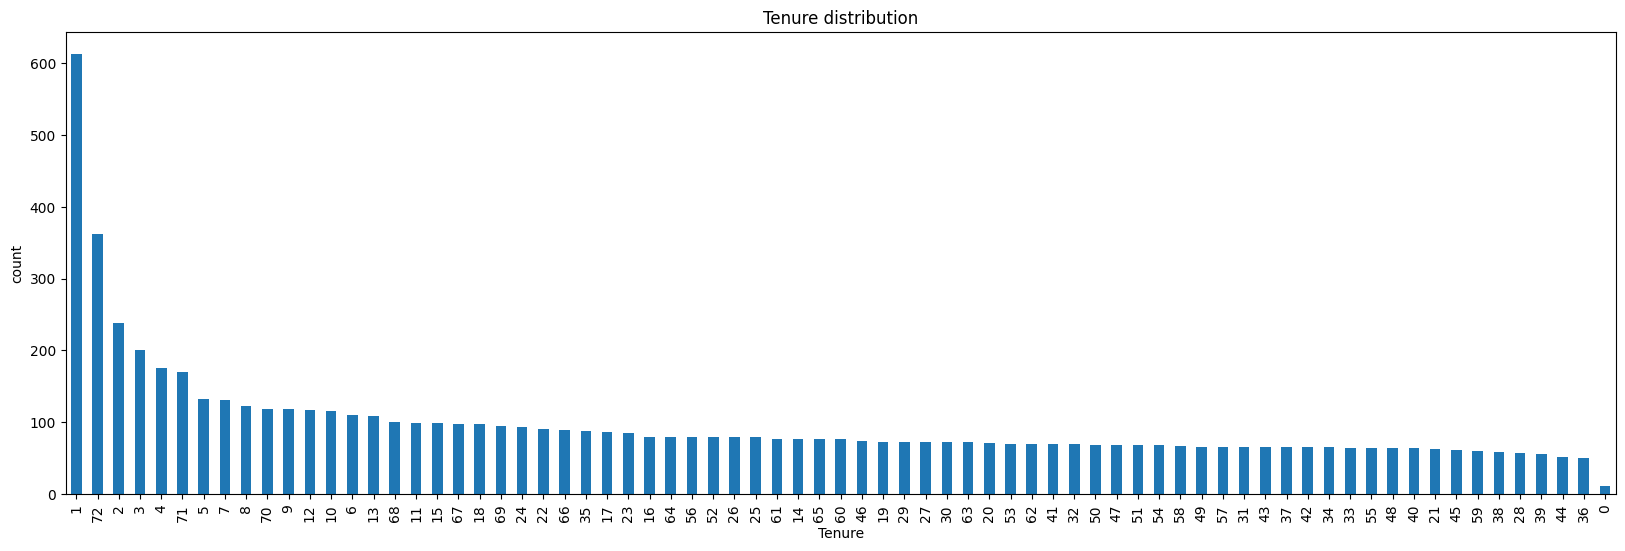

In [15]:
tenure_values = customers['tenure'].value_counts()
plt.figure(figsize=(20, 6))
tenure_values.plot(kind='bar')
plt.xlabel('Tenure')
plt.ylabel('count')
plt.title('Tenure distribution')

From observation, there are a few customers who have a tenur of 0 meaning they have spent close to no time with that particular service. These customers have not spent enough time with a service to qualify as suitable candidates to analyse hence, I will remove them from the dataset.

In [16]:
indices_to_drop = customers[customers['tenure'] == 0].index
customers.drop(indices_to_drop, inplace=True)

In [17]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


### Visual Representation

**Analysing Churn with respect to Gender**

In [18]:
churn_label = ['No', 'Yes']
gender_label = ['Male', 'Female']

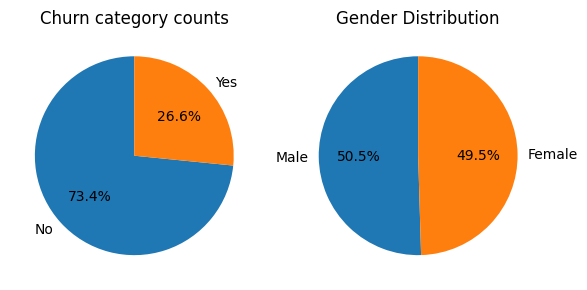

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

ax1.pie(customers['Churn'].value_counts(), labels=churn_label, autopct='%1.1f%%', startangle=90)
ax1.set_title('Churn category counts')


ax2.pie(customers['gender'].value_counts(), labels=gender_label, autopct='%1.1f%%', startangle=90)
ax2.set_title('Gender Distribution')

# Display the pie chart
plt.tight_layout()  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.show()

**Insight** - From the two graphs, gender does not contribute much to the churn category a person ends up in.

**Analysing churn with respect to (w.r.t) senior citizenship and gender**

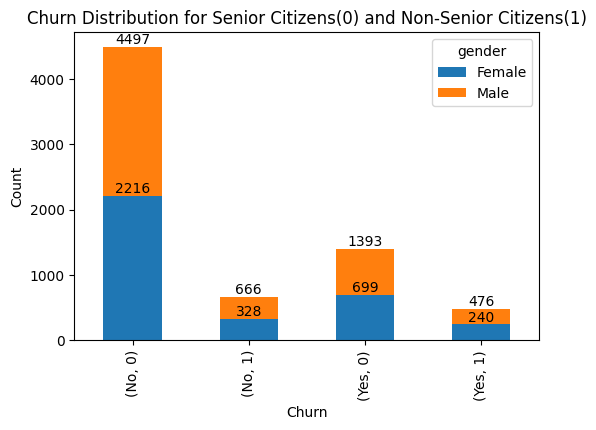

In [20]:
counts = customers.groupby(['Churn', 'SeniorCitizen', 'gender']).size().unstack(fill_value=0)

# Create a stacked bar plot
ax = counts.plot(kind='bar', stacked=True, figsize=(6, 4))

# Set labels and title
ax.set_xlabel('Churn')
ax.set_ylabel('Count')
plt.title('Churn Distribution for Senior Citizens(0) and Non-Senior Citizens(1)')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.show()

**Insight** - From observation, males who are senior citizens are mostly categorised under the no churn. This means that the combination between gender and the kind of citizen matters to the category of the churn hence they should both be attributes to be considered.

**Relationship between churn tenure**

Here I will try to see if there is some sort of relationship between the tenure of a customer and the churn category they fall in

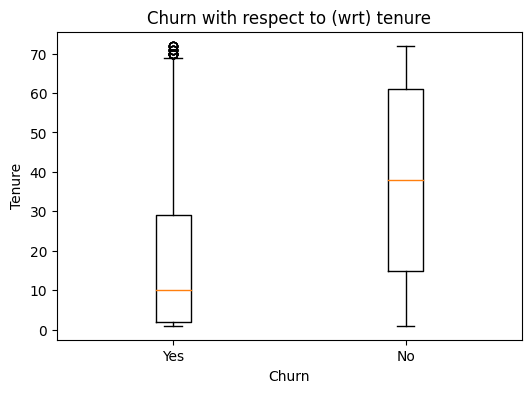

In [21]:
group_a = customers[customers['Churn'] == 'Yes']['tenure']
group_b = customers[customers['Churn'] == 'No']['tenure']

plt.figure(figsize=(6, 4))
plt.boxplot([group_a, group_b], labels=['Yes', 'No'])

plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.title('Churn with respect to (wrt) tenure')

plt.show()

**Insight** - From observation, customers who churn have a tenure close to 10 while customers who are less likely to churn have a median tenure of about 40. Hence, the tenure of a customer plays a role in determining whether or not a customer will churn.


* To add, the description the metadata of the dataset provides about tenure
and contract provides a close correlation between the tenure of a customer and the contract they have with the phone service.


* For this reason, contract will be a suitable attribute  to take into consideration when predicting the churn of a customer

**Analysing churn with respect to the Internet Service**

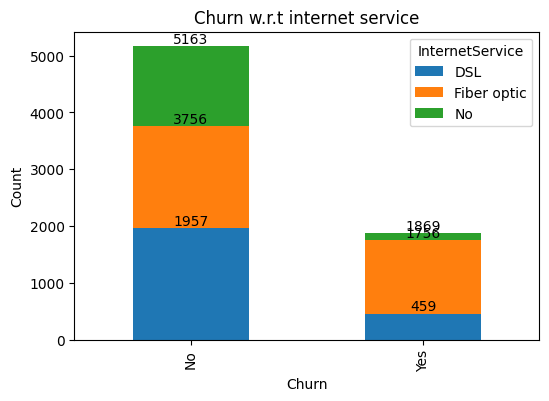

In [22]:
counts = customers.groupby(['Churn', 'InternetService']).size().unstack(fill_value=0)

# Create a stacked bar plot
ax = counts.plot(kind='bar', stacked=True, figsize=(6, 4))

# Set labels and title
ax.set_xlabel('Churn')
ax.set_ylabel('Count')
plt.title('Churn w.r.t internet service')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.show()

**Insight** - From observation, most of the customers who churn mostly use fiber optics for their internet service with a value of 1750 customers. Hence I can conclude that the internet service plays a role on the churn category of a customer.

**Analysing churn with respect to (w.r.t) online security**

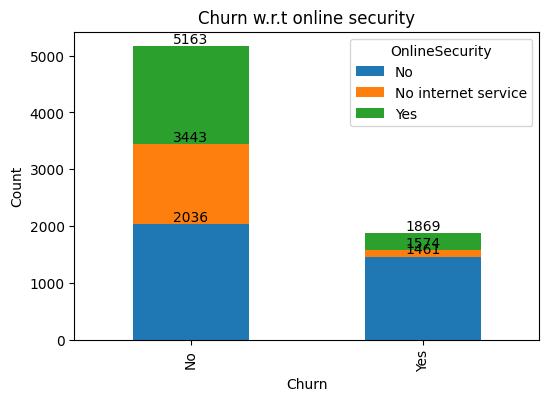

In [23]:
counts = customers.groupby(['Churn', 'OnlineSecurity']).size().unstack(fill_value=0)

# Create a stacked bar plot
ax = counts.plot(kind='bar', stacked=True, figsize=(6, 4))

# Set labels and title
ax.set_xlabel('Churn')
ax.set_ylabel('Count')
plt.title('Churn w.r.t online security')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.show()

**Insight** - From observation, customers who ususally churn do not have online security as shown with a count of 1461 persons out of 1869 customers who churn not having online security.

For this reason, I can conclude that online security can play an important role in determining the churn of a customer.

**Analysing churn with respect to online backup**

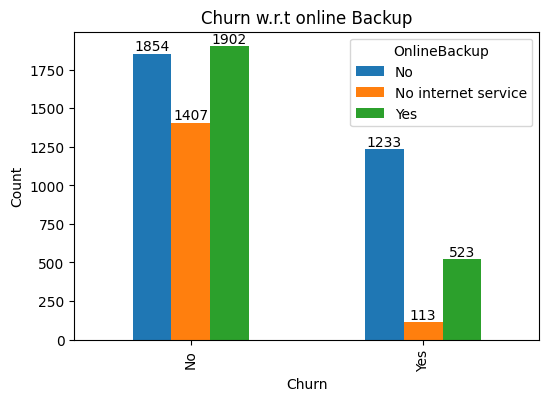

In [24]:
counts = customers.groupby(['Churn', 'OnlineBackup']).size().unstack(fill_value=0)

ax = counts.plot(kind='bar', stacked=False, figsize=(6, 4))

ax.set_xlabel('Churn')
ax.set_ylabel('Count')
plt.title('Churn w.r.t online Backup')

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

plt.show()

**Insight** - From observation, most customers who churn do not engage in online backup as is proven with a count of 1233. From this observation and the general graph structure, it is evident that whether or not a customer churns can be affected by their status in relation to Online Backup

**Analyse Churn with respect to payment method**

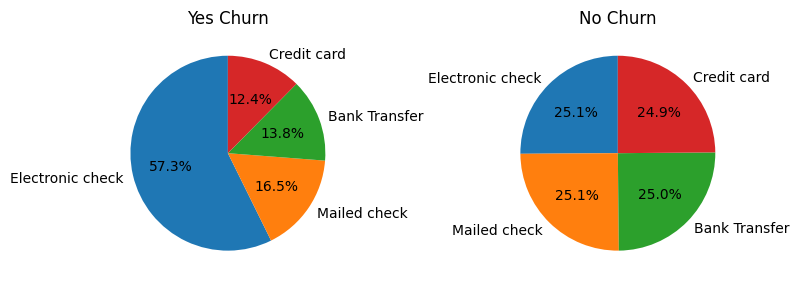

In [25]:
group_a = customers[customers['Churn'] == 'Yes']['PaymentMethod']
group_b = customers[customers['Churn'] == 'No']['PaymentMethod']

labels = ['Electronic check', 'Mailed check', 'Bank Transfer', 'Credit card']

plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.pie(group_a.value_counts().values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Yes Churn')

plt.subplot(1, 2, 2)
plt.pie(group_b.value_counts().values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('No Churn')

plt.tight_layout()

**Insight** - From observation, customers who churn tend to pay via electronic check since 57.3% of customers who churned, payed via electronic check. Hence, Payment method is an important attribute to consider when predicting the churn of a customer.

**Analysing churn with respect to MonthlyCharges**

<ipython-input-26-a58101c06caa>:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='Churn', y='MonthlyCharges', data=customers, jitter=True, dodge=False, palette='Set2')


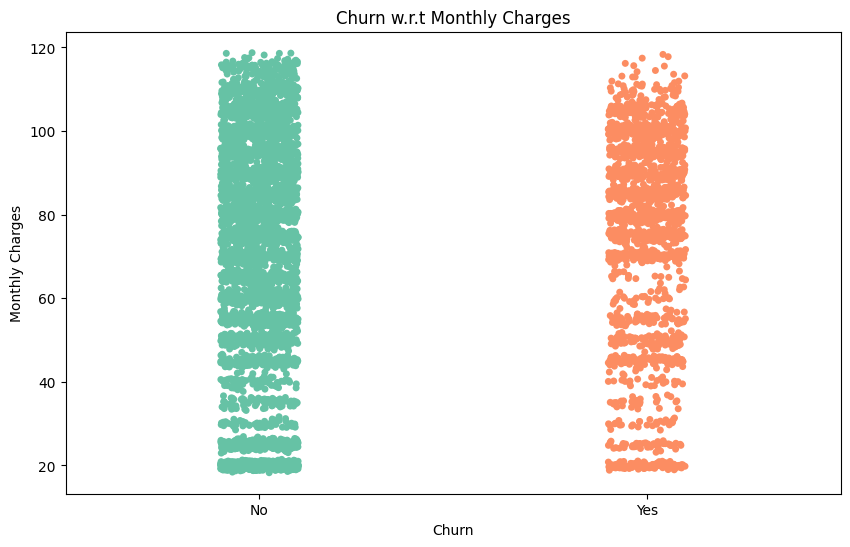

In [26]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='Churn', y='MonthlyCharges', data=customers, jitter=True, dodge=False, palette='Set2')

# Add labels and title
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.title('Churn w.r.t Monthly Charges')

# Show the plot
plt.show()

**Insight** - From observation, customers who churn pay higher montly charges than customers who do not churn. This might be due to high cost. For this reason, monthly charges are an important variable to consider when predicting churn.


This characteristic might be similar for other charges and for that reason, those charges will also be considered in prediction.

### Encoding

Here, I will encode the categorical attributes using the label encoder and not the one hot encoder to prevent the generation of a great number of extra columns

In [28]:
lb = LabelEncoder()

Create data frame of attributes to be encoded

In [29]:
categorical = customers.select_dtypes(include=['object'])
categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            7032 non-null   object
 1   Partner           7032 non-null   object
 2   Dependents        7032 non-null   object
 3   PhoneService      7032 non-null   object
 4   MultipleLines     7032 non-null   object
 5   InternetService   7032 non-null   object
 6   OnlineSecurity    7032 non-null   object
 7   OnlineBackup      7032 non-null   object
 8   DeviceProtection  7032 non-null   object
 9   TechSupport       7032 non-null   object
 10  StreamingTV       7032 non-null   object
 11  StreamingMovies   7032 non-null   object
 12  Contract          7032 non-null   object
 13  PaperlessBilling  7032 non-null   object
 14  PaymentMethod     7032 non-null   object
 15  Churn             7032 non-null   object
dtypes: object(16)
memory usage: 933.9+ KB


Encode these attributes with a label encoder

In [31]:
categorical = categorical.apply(lb.fit_transform)
categorical.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


Create a data frame of numerical attributes and add them to the label encoded categorical dataset as a single dataset

In [32]:
numerical = customers.select_dtypes(exclude=['object'])
numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SeniorCitizen   7032 non-null   int64  
 1   tenure          7032 non-null   int64  
 2   MonthlyCharges  7032 non-null   float64
 3   TotalCharges    7032 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 274.7 KB


In [33]:
customers_df = pd.concat([categorical, numerical], axis=1)
customers_df

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0,0,1,29.85,29.85
1,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0,0,34,56.95,1889.50
2,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1,0,2,53.85,108.15
3,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0,0,45,42.30,1840.75
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1,0,2,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,1,1,2,0,2,0,2,2,2,2,1,1,3,0,0,24,84.80,1990.50
7039,0,1,1,1,2,1,0,2,2,0,2,2,1,1,1,0,0,72,103.20,7362.90
7040,0,1,1,0,1,0,2,0,0,0,0,0,0,1,2,0,0,11,29.60,346.45
7041,1,1,0,1,2,1,0,0,0,0,0,0,0,1,3,1,1,4,74.40,306.60


## Feature Engineering

* Based on the graphical analysis I conducted, all the attributes remaining in the data set will be important in predicting the churn of a customer. Hence, all of these attributes will be used in training my model further on.

* Secondly, the correlation method will not be used here because these attributes have a very low correlation with churn. Hence, non of them, according to churn will be good enough to use for prediction.

**X attributes and Y attributes**

Identify dependent and Independent variable as Y and X

In [34]:
X = customers_df.drop(columns='Churn')
Y = customers_df.Churn

**Scaling**

To ensure there is no bias towards large numerical values, I will scale my X attributes using the Standard Scaler

In [35]:
sc = StandardScaler()

In [36]:
scaled_data = sc.fit_transform(X)
X = pd.DataFrame(scaled_data, columns=X.columns)
X

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,-1.009430,1.035617,-0.652305,-3.056334,0.062666,-1.183614,-0.917837,1.242875,-1.026988,-0.924267,-1.112632,-1.121501,-0.826735,0.828939,0.399805,-0.440327,-1.280248,-1.161694,-0.994194
1,0.990658,-0.965608,-0.652305,0.327189,-0.991564,-1.183614,1.408012,-1.028998,1.245441,-0.924267,-1.112632,-1.121501,0.373926,-1.206361,1.336636,-0.440327,0.064303,-0.260878,-0.173740
2,0.990658,-0.965608,-0.652305,0.327189,-0.991564,-1.183614,1.408012,1.242875,-1.026988,-0.924267,-1.112632,-1.121501,-0.826735,0.828939,1.336636,-0.440327,-1.239504,-0.363923,-0.959649
3,0.990658,-0.965608,-0.652305,-3.056334,0.062666,-1.183614,1.408012,-1.028998,1.245441,1.396963,-1.112632,-1.121501,0.373926,-1.206361,-1.473857,-0.440327,0.512486,-0.747850,-0.195248
4,-1.009430,-0.965608,-0.652305,0.327189,-0.991564,0.172835,-0.917837,-1.028998,-1.026988,-0.924267,-1.112632,-1.121501,-0.826735,0.828939,0.399805,-0.440327,-1.239504,0.196178,-0.940457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.990658,1.035617,1.533025,0.327189,1.116896,-1.183614,1.408012,-1.028998,1.245441,1.396963,1.146689,1.137564,0.373926,0.828939,1.336636,-0.440327,-0.343137,0.664868,-0.129180
7028,-1.009430,1.035617,1.533025,0.327189,1.116896,0.172835,-0.917837,1.242875,1.245441,-0.924267,1.146689,1.137564,0.373926,0.828939,-0.537026,-0.440327,1.612573,1.276493,2.241056
7029,-1.009430,1.035617,1.533025,-3.056334,0.062666,-1.183614,1.408012,-1.028998,-1.026988,-0.924267,-1.112632,-1.121501,-0.826735,0.828939,0.399805,-0.440327,-0.872808,-1.170004,-0.854514
7030,0.990658,1.035617,-0.652305,0.327189,1.116896,0.172835,-0.917837,-1.028998,-1.026988,-0.924267,-1.112632,-1.121501,-0.826735,0.828939,1.336636,2.271039,-1.158016,0.319168,-0.872095


Now I will split my dataset into training data, validation data, and testing data based on a 80% training, to 10% validation, and 10% testing division.

In [37]:
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.2, random_state=42)

In [38]:
Xvalidation, Xtest, Yvalidation, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5, random_state=42)

# Model Development

Here I will build a multi-layer perceptron model using the functinal api and train the model

**Define and connect layers**

In [39]:
visible = Input(shape=(X.shape[1],)) # input layer
hidden1 = Dense(64, activation= 'relu' )(visible)
out = Dropout(0.0)(hidden1)
hidden2 = Dense(32, activation= 'relu' )(out)
out = Dropout(0.4)(hidden2)
hidden3 = Dense(32, activation= 'relu' )(out)
out = Dropout(0.0)(hidden3)
hidden4 = Dense(24, activation= 'relu' )(out)
out = Dropout(0.0)(hidden4)
output = Dense(1, activation= 'sigmoid')(out)


**Use of class_weight**

Calculate the class weight of the classes to solve the problem of inbalanced classifying in dataset

In [40]:
class_labels = np.unique(Ytrain)
class_weights = class_weight.compute_class_weight('balanced', classes=class_labels, y=Ytrain)

In [41]:
model = Model(inputs=visible, outputs=output)

* The loss function is binary_crossentropy due to the fact that my classification is either yes for churn or no for churn

* My learning rate is starting off with a 0.0001 value just for starting purposes

* And my optimizer is the Adam optimizer because it's the most efficient and accurate when finding the global minimum of the loss function

In [42]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

## Training and validation

Train model with training data and validation data while tracking;

* the loss value
* accuracy of the model
* over 150 epochs and
* a batch size of 32

In [43]:
model.fit(Xtrain, Ytrain, epochs=150, batch_size=32, class_weight=dict(zip(class_labels, class_weights)), validation_data=(Xvalidation, Yvalidation))

Epoch 1/150
176/176 [==============================] - 2s 4ms/step - loss: 0.6805 - accuracy: 0.6578 - val_loss: 0.6364 - val_accuracy: 0.7183
Epoch 2/150
176/176 [==============================] - 1s 3ms/step - loss: 0.6338 - accuracy: 0.6955 - val_loss: 0.5954 - val_accuracy: 0.7155
Epoch 3/150
176/176 [==============================] - 1s 3ms/step - loss: 0.5785 - accuracy: 0.7097 - val_loss: 0.5388 - val_accuracy: 0.7269
Epoch 4/150
176/176 [==============================] - 1s 3ms/step - loss: 0.5473 - accuracy: 0.7225 - val_loss: 0.5240 - val_accuracy: 0.7326
Epoch 5/150
176/176 [==============================] - 1s 3ms/step - loss: 0.5264 - accuracy: 0.7246 - val_loss: 0.5099 - val_accuracy: 0.7368
Epoch 6/150
176/176 [==============================] - 1s 3ms/step - loss: 0.5317 - accuracy: 0.7257 - val_loss: 0.5141 - val_accuracy: 0.7326
Epoch 7/150
176/176 [==============================] - 1s 3ms/step - loss: 0.5157 - accuracy: 0.7301 - val_loss: 0.5076 - val_accuracy: 0.7397

In [44]:
_, accuracy = model.evaluate(Xtrain, Ytrain)
print("The accuracy of my model with the training data is ", accuracy*100, "%")

176/176 [==============================] - 0s 2ms/step - loss: 0.4082 - accuracy: 0.8018
The accuracy of my model with the training data is  80.17777800559998 %


In [45]:
_, accuracy2 = model.evaluate(Xvalidation, Yvalidation)
print("The accuracy of my model with the validation data is ", accuracy2*100, "%")

22/22 [==============================] - 0s 2ms/step - loss: 0.4840 - accuracy: 0.7525
The accuracy of my model with the validation data is  75.24893283843994 %


Due to the little difference between the accuracy of my model with the training split and the accuracy of my model with the validation split, my model has not been overfitted.

## Evaluation of model

Here, I will test the ability of the model to generalise by testing it on the testing split of the dataset

In [46]:
prediction = model.predict(Xtest)

22/22 [==============================] - 0s 3ms/step


In [47]:
auc_score = metrics.roc_auc_score(Ytest, prediction)
print("The AUC score of the model is:", round(auc_score,5))

The AUC score of the model is: 0.80237


In [48]:
threshold = 0.3  # Adjust the threshold based on your problem
prediction_classes = np.where(prediction > threshold, 1, 0)

print("Classification Report")
print(classification_report(Ytest, prediction_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.58      0.71       505
           1       0.45      0.85      0.59       199

    accuracy                           0.66       704
   macro avg       0.68      0.72      0.65       704
weighted avg       0.78      0.66      0.68       704



#Hyperparameter Tuning

Create model in method for tuning purposes. Do this by creating model with parameters;

* optimizer

In [49]:
def create_model(optimizer='Adam'):
  visible = Input(shape=(X.shape[1],)) # input layer
  hidden1 = Dense(64, activation= 'relu' )(visible)
  out = Dropout(0.0)(hidden1)
  hidden2 = Dense(32, activation= 'relu' )(out)
  out = Dropout(0.4)(hidden2)
  hidden3 = Dense(32, activation= 'relu' )(out)
  out = Dropout(0.0)(hidden3)
  hidden4 = Dense(24, activation= 'relu' )(out)
  out = Dropout(0.0)(hidden4)
  output = Dense(1, activation= 'sigmoid')(out)

  model = Model(inputs=visible, outputs=output)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  return model

Next, I will specifiy the parameters which I am looking to alter to hypertune the model

In [50]:
param_grid = {
    #'neurons': [20, 30, 10],
    'batch_size' : [32, 64, 128],
    'epochs': [250, 200, 150],
    'optimizer': ['SGD', 'Adam', 'RMSprop'],
    'class_weight': [dict(zip(class_labels, class_weights))]
}

In [51]:
k_model = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)

Perform hyperparameter tuning using the gridsearchCV with,

* KerasClassifier model
* n_jobs with value 1
* cv value of 3

In [52]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=k_model, param_grid=param_grid, n_jobs=-1, cv=cv)

In [53]:
result = grid.fit(Xvalidation, Yvalidation)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [54]:
print("Best accuracy:",result.best_score_)
print("Best parameters:",result.best_params_)

Best accuracy: 0.761063829787234
Best parameters: {'batch_size': 64, 'class_weight': {0: 0.6809927360774818, 1: 1.8812709030100334}, 'epochs': 150, 'optimizer': 'RMSprop'}


In [55]:
best_model = result.best_estimator_
cw = result.best_params_['class_weight']

In [56]:
best_model.fit(Xtrain, Ytrain, epochs=200, batch_size=64,validation_data=(Xvalidation, Yvalidation))

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


KerasClassifier(
	model=None
	build_fn=<function create_model at 0x7bba7d726b00>
	warm_start=False
	random_state=None
	optimizer=RMSprop
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=150
	class_weight={0: 0.6809927360774818, 1: 1.8812709030100334}
)

In [57]:
prediction_2 = best_model.predict(Xtest)
auc_score_2 = metrics.roc_auc_score(Ytest, prediction_2)
print("The AUC score of the model is:", round(auc_score_2,5))

The AUC score of the model is: 0.70196


Next, I analysed the classification report of the model after adjusting the threshold for a no churn and a yes churn for a customer.

This threshold was determined by the values relating to the distribution of No churns and Yes churns I arrived out during EDA.


In [58]:
threshold = 0.3  # Adjust the threshold based on your problem
prediction_classes = np.where(prediction > threshold, 1, 0)

print("Classification Report")
print(classification_report(Ytest, prediction_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.58      0.71       505
           1       0.45      0.85      0.59       199

    accuracy                           0.66       704
   macro avg       0.68      0.72      0.65       704
weighted avg       0.78      0.66      0.68       704



# Save Model

To properly save the model for loading later on my web platform, I will save three files

* an h5 file containing my model
* a pickle file containing the encoder object
* a pickle file containing the scaler object

The last two files listed is to ensure that the user input is processed in the right way before passed on the model

In [59]:
path = "/content/drive/MyDrive/Colab Notebooks/"

In [60]:
to_save = grid.best_estimator_.build_fn('RMSProp')

In [61]:
to_save.save(path + "churn_class_3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
with open(path + "label_encoder_1.pkl", "wb") as file:
  pickle.dump(lb, file)

In [63]:
with open(path + "scaler_1.pkl", "wb") as file:
  pickle.dump(sc, file)